## Citibikes EDA: Potential Failure Rates

In [32]:
# Setup for notebook

# Setup for pd, sns and plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setup for BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

In [24]:
# Path to service account JSON
key_path = '/home/shaunycl/test2/ntu-sctp-dsai1f-project-team6/meltano-learn-ntu-ca618302dc13.json'

# Create credentials and BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [29]:
query = """
    SELECT 
        trip_id,
        bike_type_id,
        distance_metres,
        duration_mins,
        membership_type_id,
        price_paid
    FROM 
        `meltano-learn-ntu.citibike_dbt.fact_trips`
    ORDER BY RAND()
    LIMIT 10000
"""

# Run the query and load results into pandas DataFrame
df = client.query(query).to_dataframe()


In [38]:
# Map IDs to Readable names
# f37b539769f48b546ee51fc0be867626 is classic_bike
# f877892b7f02356b109fce82d4dfc5ca is electric_bike

# Define the mapping
bike_type_mapping = {
    'f37b539769f48b546ee51fc0be867626': 'classic_bike',
    'f877892b7f02356b109fce82d4dfc5ca': 'electric_bike'
}

# Apply it to create new column
df['bike_type_name'] = df['bike_type_id'].map(bike_type_mapping)

In [44]:
df.info()
df.describe()

# Failure flag logic
df['suspected_failure'] = (
    (df['duration_mins'] < 1) |
    (df['duration_mins'] > 180) |
    (df['distance_metres'] == 0) |
    (df['distance_metres'] > 10000)
).astype(int)

# Failure rate by bike type
df.groupby('bike_type_name')['suspected_failure'].mean()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trip_id             10000 non-null  object 
 1   bike_type_id        10000 non-null  object 
 2   distance_metres     9999 non-null   Int64  
 3   duration_mins       10000 non-null  Int64  
 4   membership_type_id  10000 non-null  object 
 5   price_paid          10000 non-null  float64
 6   suspected_failure   10000 non-null  int64  
 7   bike_type_name      10000 non-null  object 
dtypes: Int64(2), float64(1), int64(1), object(4)
memory usage: 644.7+ KB


bike_type_name
classic_bike     0.062175
electric_bike    0.033138
Name: suspected_failure, dtype: float64

/tmp/ipykernel_9069/1814614892.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


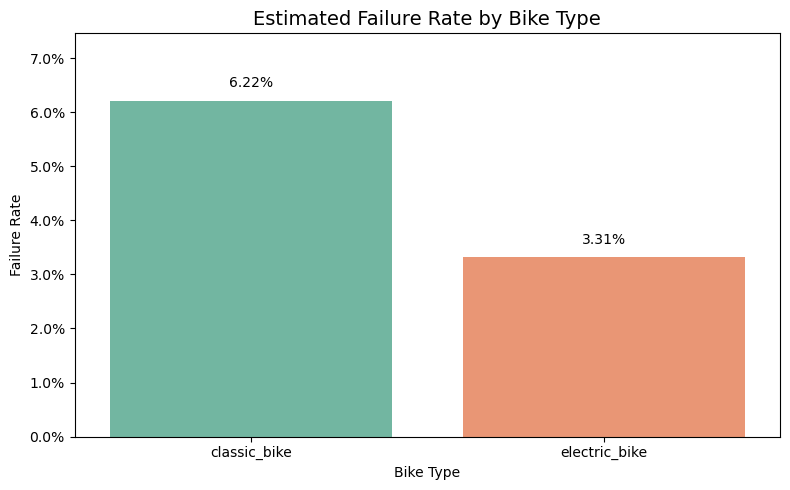

In [ ]:
failure_by_bike = df.groupby('bike_type_name')['suspected_failure'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=failure_by_bike,
    x='bike_type_name',
    y='suspected_failure',
    palette='Set2'
)

plt.title('Estimated Failure Rate by Bike Type', fontsize=14)
plt.ylabel('Failure Rate')
plt.xlabel('Bike Type')
plt.ylim(0, failure_by_bike['suspected_failure'].max() * 1.2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Show exact values on top of bars
for index, row in failure_by_bike.iterrows():
    plt.text(index, row['suspected_failure'] + 0.002, f"{row['suspected_failure']:.2%}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()